In [23]:
import matplotlib.pyplot as plt
import numpy as np
import xarray
import tensorflow as tf
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [24]:
def correlation(x, y):
    x0 = x - np.mean(x, axis = 0)
    y0 = y - np.mean(y, axis = 0)
    return np.mean(x0 * y0, axis = 0) / np.sqrt((np.mean(x0**2, axis = 0) * (np.mean(y0**2, axis = 0))))

# Extracting SST, ONI and Anomaly

In [25]:
datapath = 'nino34_monthly.nc'
nino34 = xarray.open_dataset(datapath, decode_times = False)
nino34 = np.array((nino34['nino34'].values)[12 * 50:])

In [26]:
def ONI(nino34, m = 3):
    oni = np.array(nino34)
    length = nino34.shape[0]
    for i in range(length):
        oni[i] = np.mean(nino34[max(0, (i - m + 1)) : min((i + 1), length)])
    return oni

In [27]:
def climatology(nino34):
    clm = np.zeros(12)
    length = nino34.shape[0]
    for month in range(12):
        section = [12 * i + month for i in range(length // 12)]
        clm[month] = np.mean(nino34[section])
    return clm

In [28]:
clm = climatology(nino34)

In [29]:
def SST_anomaly(nino34, clm):
    return (nino34.reshape((nino34.shape[0] // 12, 12)) - clm).flatten()

In [30]:
anm = SST_anomaly(nino34, clm)
oni = ONI(anm)
time = np.arange(anm.shape[0])

# Converting Time Series to Train/Validation/Test Datasets and Labels

We first decide which time series to use for training (input_signal) and which time series to predict (output_signal):

In [9]:
input_signal = np.array(anm).copy()
output_signal = np.array(oni).copy()

We then normalize the input signal for more reliable performance:

In [10]:
mean = np.mean(input_signal)
std = np.std(input_signal)

input_signal = (input_signal - mean) / std

We now decide how far into the future we aim to predict (T months into the future) and how much history we use to do so (H months of past values).

In [11]:
T = 12
H = 48

Based on H and T, we can create: 
(1) the history matrix, i.e. the data to be used to predict the future time series value, and
(2) the desired label vector.

In [12]:
np.random.seed(0)
size = input_signal.shape[0] - H - T  # effective dataset size (need to discount history and maximal prediction timeline)
        
# create the 'history matrix'
data = np.ndarray((size, H))
for i in range(size):
    data[i] = input_signal[i:(i + H)]

labels = np.ndarray((size, T), dtype = np.float64)
time2D = np.zeros((size, T))

for t in range(T):
    for i in range(size):
        labels[i, t] = output_signal[i + H + t]
        time2D[i, t] = time[i + H + t]

We will use the first 80% of the time series as training data, the following 10% as validation and the last 10% for testing:

In [13]:
split = size // 10      

train = np.array(data[0: 8 * split])
train_labels = np.array(labels[0: 8 * split])

val = np.array(data[8 * split: 9 * split])
val_labels = np.array(labels[8 * split: 9 * split])
val_time2D = np.array(time2D[8 * split: 9 * split])

test = np.array(data[9 * split: size])
test_labels = np.array(labels[9 * split: size])

(Optional) Shuffle Training Data

In [14]:
shuffle = np.random.permutation(8 * split)
train = train[shuffle]
train_labels = train_labels[shuffle]

# Learning Optimal Weights for each t = 1, T separately: 

We first establish the network architecture, the dropout and the number of epochs.

In [15]:
(N1, N2, N3, d) = (192, 768, 768, 0.5)
epochs = 40

individual_model = tf.keras.models.Sequential([
                  tf.keras.layers.Dense(N1,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(N2,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(N3,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(1,  kernel_initializer='normal', activation = 'linear')
        ])

In [16]:
val_pred_mse = np.zeros(T)
val_pred_corr = np.zeros(T)

In [17]:
individual_val_pred = {}

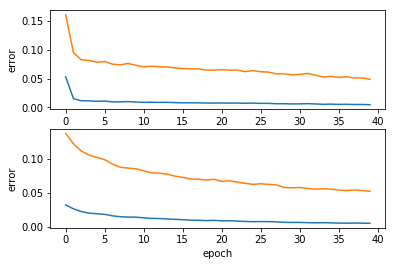

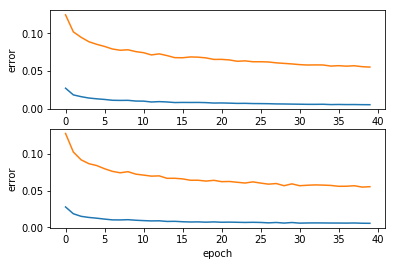

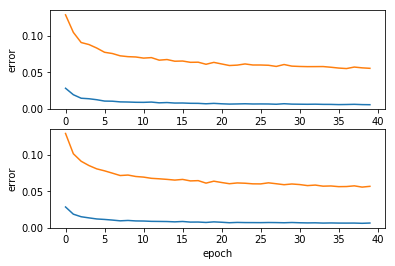

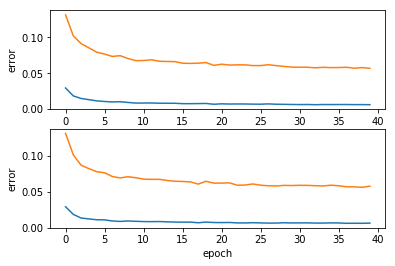

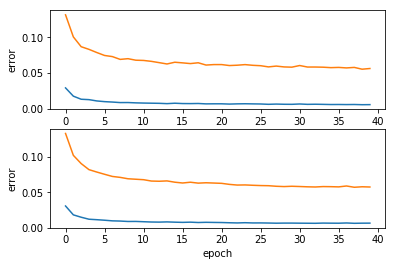

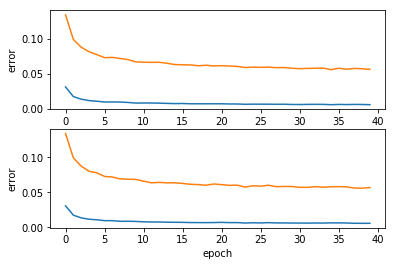

<Figure size 432x288 with 0 Axes>

In [18]:
for t in range(T):
    
    individual_model.reset_states()

    individual_model.compile(optimizer='adam', loss='mae', metrics=['mse', 'mae'])

    individual_history = individual_model.fit(train, train_labels[:, t], epochs = epochs, verbose = 0)
    
    individual_val_pred[t] = individual_model.predict(val).flatten() # save individual predictions for t
    
    val_pred_mse[t] = mean_squared_error(val_labels[:, t].flatten(), individual_val_pred[t])
    val_pred_corr[t] = correlation(val_labels[:, t].flatten(), individual_val_pred[t])
    
    # Plotting Training
    plt.subplot(2, 1, t % 2 + 1);
    
    plt.plot(individual_history.history['mean_squared_error']);
    plt.plot(individual_history.history['mean_absolute_error']);
    plt.ylabel('error');
    plt.xlabel('epoch');
    
    if((1 + t) % 2 == 0):
        plt.figure();

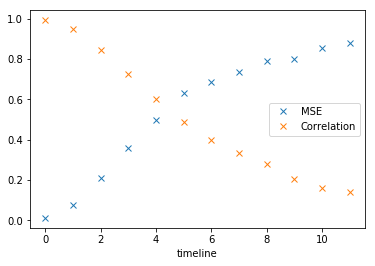

In [19]:
plt.plot(val_pred_mse, 'x', label = "MSE");
plt.plot(val_pred_corr, 'x', label = "Correlation");
plt.xlabel('timeline');
plt.legend();

# Learning Optimal Weights for all t simulatously: 

In [20]:
epochs = 100

Modifying the number of output values to T:

In [21]:
cumulative_model = tf.keras.models.Sequential([
                  tf.keras.layers.Dense(N1,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(N2,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(N3,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(T,  kernel_initializer='normal', activation = 'linear')
        ])

Learning using all labels simultanously:

In [31]:
cumulative_model.reset_states()

cumulative_model.compile(optimizer='adam', loss='mae', metrics=['mse', 'mae'])

cumulative_history = cumulative_model.fit(train, train_labels, epochs = epochs, verbose = 0)

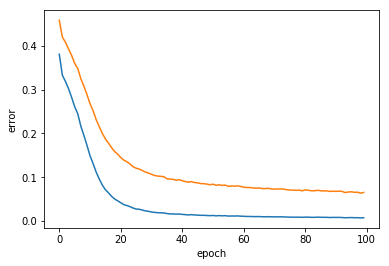

In [32]:
plt.plot(cumulative_history.history['mean_squared_error'], label = "MSE");
plt.plot(cumulative_history.history['mean_absolute_error'], label = "MAE");
plt.ylabel('error');
plt.xlabel('epoch');

In [33]:
cumulative_val_pred = cumulative_model.predict(val)

In [34]:
mult_val_pred_mse = np.zeros(T)
mult_val_pred_corr = np.zeros(T)

mult_val_pred_mse = ((val_labels - cumulative_val_pred)**2).mean(axis = 0)
mult_val_pred_corr = correlation(val_labels, cumulative_val_pred)

Plotting results of cumulative versus individual learning:

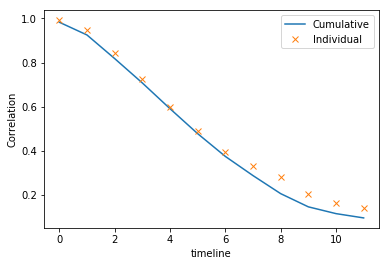

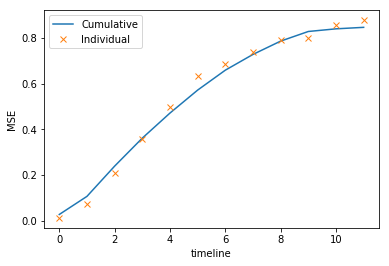

In [35]:
plt.plot(mult_val_pred_corr, label = "Cumulative");
plt.plot(val_pred_corr, 'x', label = "Individual");
plt.ylabel('Correlation');
plt.xlabel('timeline');
plt.legend();
plt.figure();

plt.plot(mult_val_pred_mse, label = "Cumulative");
plt.plot(val_pred_mse, 'x', label = "Individual");
plt.ylabel('MSE');
plt.xlabel('timeline');
plt.legend();

In [36]:
monthly_corr = np.zeros((12, T))
for m in range(12):
    monthly_corr[m] = correlation(val_labels[m::12], cumulative_val_pred[m::12])

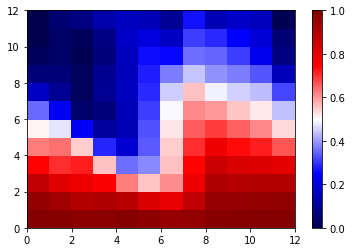

In [37]:
plt.pcolormesh(monthly_corr.T, cmap = plt.cm.seismic);
plt.clim(0, 1)
plt.colorbar();

In [38]:
monthly_rmse = np.zeros((12, T))
for m in range(12):
    monthly_rmse[m] = ((val_labels[m::12] - cumulative_val_pred[m::12])**2).mean(axis = 0)

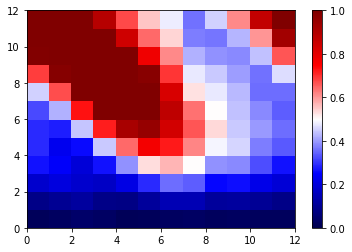

In [39]:
plt.pcolormesh(monthly_rmse.T, cmap = plt.cm.seismic);
plt.clim(0, 1)
plt.colorbar();

# Plotting Predicted Time Series Against True Time Series [SEPARATE]

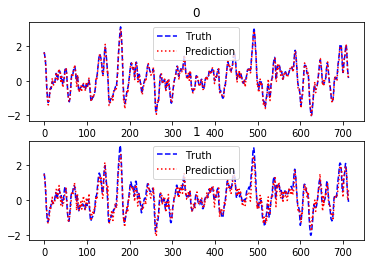

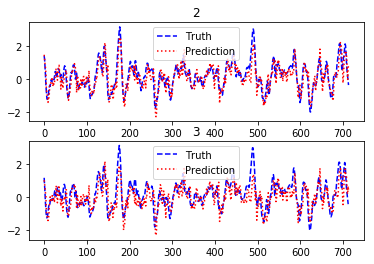

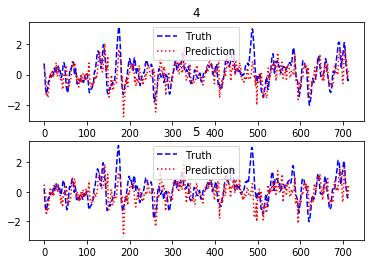

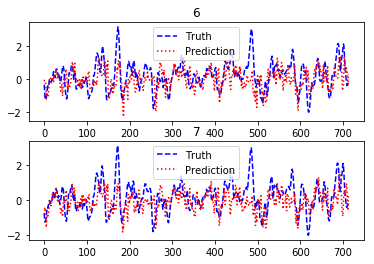

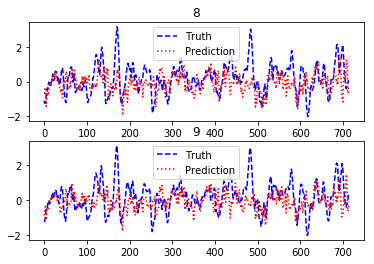

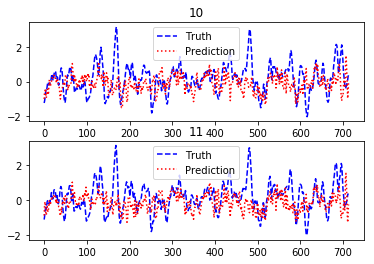

<Figure size 432x288 with 0 Axes>

In [40]:
for t in range(T):
    plt.subplot(2, 1, t % 2 + 1);
    plt.plot(val_labels[:, t], '--', label = "Truth", color = 'blue');
    plt.plot(individual_val_pred[t], ':', label = "Prediction", color = 'red');
    plt.title(t);
    plt.legend();
    if((1 + t) % 2 == 0):
        plt.figure();

# Plotting Predicted Time Series Against True Time Series [CUMULATIVE]

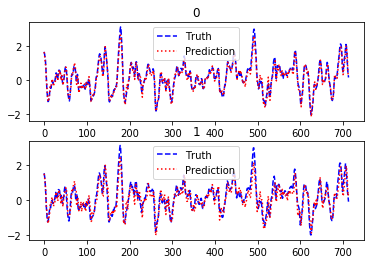

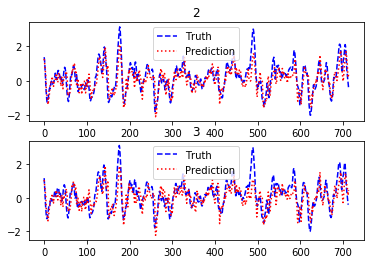

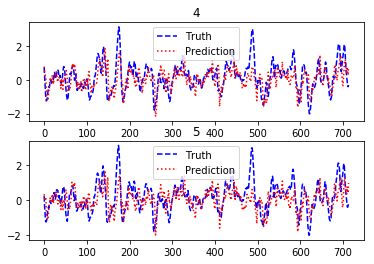

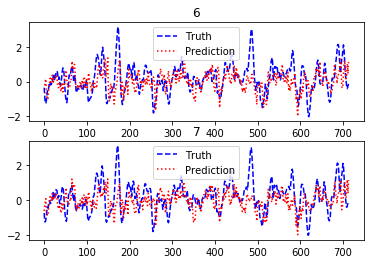

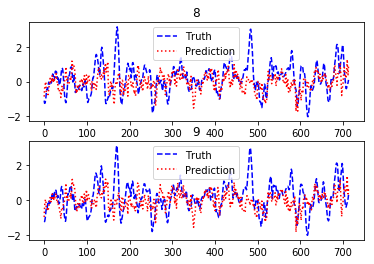

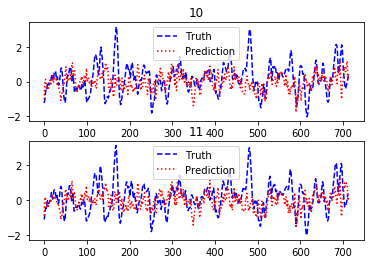

<Figure size 432x288 with 0 Axes>

In [41]:
for t in range(T):
    plt.subplot(2, 1, t % 2 + 1);
    plt.plot(val_labels[:, t], '--', label = "Truth", color = 'blue');
    plt.plot(cumulative_val_pred[:, t], ':', label = "Prediction", color = 'red');
    plt.title(t);
    plt.legend();
    if((1 + t) % 2 == 0):
        plt.figure();

In [42]:
start = 0 * 12
end = start + 5 * 12

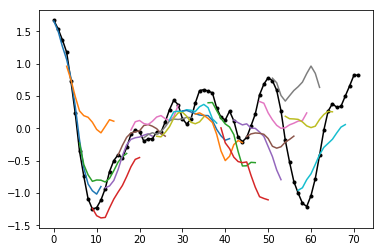

In [43]:
plt.plot(val_time2D[start:end + 12, 0].T - val_time2D[start, 0], val_labels[start:end + 12, 0], "k.-", label = "signal");
for t in range(start, end, 3):
    plt.plot(val_time2D[t] - val_time2D[start, 0], cumulative_val_pred[t], label = "%i" %(t % 12));

#plt.plot(val_time2D[start:end].T - val_time2D[start, 0], cumulative_val_pred[start:end].T);

# Comparing to Persistance

In [44]:
persistance_corr = np.zeros(T)
persistance_mse = np.zeros(T)

for t in range(T):
    persistance_corr[t] = correlation(output_signal[:(- t - 1)], output_signal[(t + 1):])
    persistance_mse[t] = mean_squared_error(output_signal[:(- t - 1)], output_signal[(t + 1):])

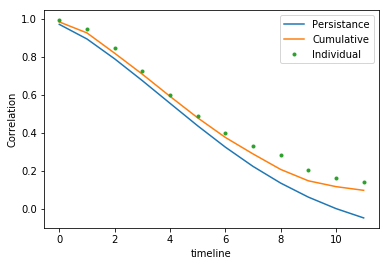

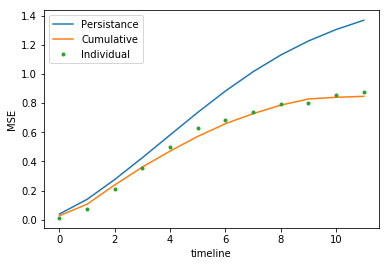

In [45]:
plt.plot(persistance_corr, label = "Persistance");
plt.plot(mult_val_pred_corr, label = "Cumulative");
plt.plot(val_pred_corr, '.', label = "Individual");
plt.ylabel('Correlation');
plt.xlabel('timeline');
plt.legend();
plt.figure();


plt.plot(persistance_mse, label = "Persistance");
plt.plot(mult_val_pred_mse, label = "Cumulative");
plt.plot(val_pred_mse, '.', label = "Individual");
plt.ylabel('MSE');
plt.xlabel('timeline');
plt.legend();

# Performance on Real World Data

First we extract relevant time series:

In [46]:
datapath = 'om_nino34_monthly.nc'
om_nino34 = xarray.open_dataset(datapath, decode_times = False)
om_nino34 = np.array(om_nino34['nino34'].values)

/Users/paulag/anaconda3/lib/python3.6/site-packages/xarray/conventions.py:362: SerializationWarning: variable 'areacello' has multiple fill values {-1e+34, 1e+20}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)


In [47]:
om_clm = climatology(om_nino34)
om_anm = SST_anomaly(om_nino34, om_clm)
om_oni = ONI(om_anm)

We decide which time series to use as input and which as desired output and normalize the input.

In [48]:
om_input_signal = np.array(om_oni)
om_output_signal = np.array(om_oni)

om_input_signal = (om_input_signal - np.mean(om_input_signal)) / np.std(om_input_signal)

In [49]:
om_size = om_input_signal.shape[0] - H - T 
om_data = np.ndarray((om_size, H))
for i in range(om_size):
    om_data[i] = om_input_signal[i:(i + H)]

om_labels = np.ndarray((om_size, T), dtype = np.float64)

for t in range(T):
    for i in range(om_size):
        om_labels[i,t] = om_output_signal[i + H + t]

Vizualize correlation between predictions and true labels:

In [50]:
om_pred = cumulative_model.predict(om_data)

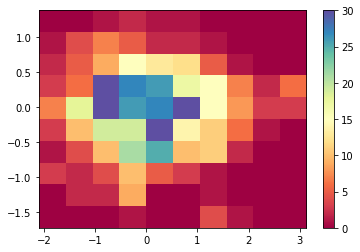

In [51]:
plt.hist2d(om_labels[:,-1], om_pred[:,-1], cmap = plt.cm.Spectral, vmax = 30);
plt.colorbar();

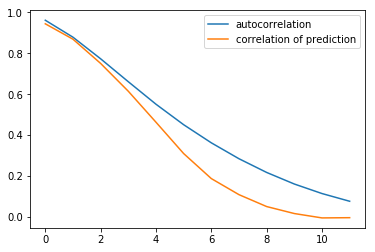

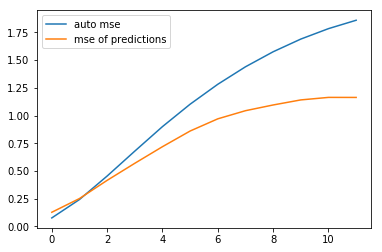

In [52]:
om_auto = np.zeros(T)
om_mse = np.zeros(T)

for t in range(T):
    om_auto[t] = correlation(om_anm[:(- t - 1)], om_anm[(t + 1):])
    om_mse[t] = mean_squared_error(om_anm[:(- t - 1)], om_anm[(t + 1):])
    
om_pred_mse = ((om_labels - om_pred)**2).mean(axis = 0)

plt.plot(om_auto, label = "autocorrelation");
plt.plot(correlation(om_labels, om_pred), label = "correlation of prediction");
plt.legend();
plt.figure();

plt.plot(om_mse, label = "auto mse");
plt.plot(om_pred_mse, label = "mse of predictions")
plt.legend();